<a href="https://colab.research.google.com/github/dk361646/Predictive-Maintenance---Colour-Coating-Steel-Industry/blob/main/Predictive_Maintenance_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('motor.csv', parse_dates=['timestamp'])

In [3]:
df.head()

,timestamp,motor_id,temp,vibration,current,line_speed,coil_thickness,failure,RUL
0,01-01-2023 00:00,M01,70.747267,0.061319,16.166984,113.686765,0.47,0,64
1,01-01-2023 00:00,M04,72.463755,0.026315,13.686070,110.227913,0.37,0,63
2,01-01-2023 00:00,M02,73.595204,0.045536,15.530943,112.329933,0.47,0,62
3,01-01-2023 00:00,M03,71.466077,0.042922,14.001663,117.708550,0.37,0,61
4,01-01-2023 00:00,M05,77.632179,0.050428,14.924172,113.015555,0.37,0,60


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       50000 non-null  object 
 1   motor_id        50000 non-null  object 
 2   temp            50000 non-null  float64
 3   vibration       50000 non-null  float64
 4   current         50000 non-null  float64
 5   line_speed      50000 non-null  float64
 6   coil_thickness  50000 non-null  float64
 7   failure         50000 non-null  int64  
 8   RUL             50000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 3.4+ MB


In [5]:
df.describe()

,temp,vibration,current,line_speed,coil_thickness,failure,RUL
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,72.325121,0.075774,14.608559,107.461652,0.519939,0.020000,48.219360
std,3.846826,0.100382,1.557418,10.273275,0.180074,0.140001,43.872308
min,62.463167,0.000000,10.376813,58.360903,0.280000,0.000000,0.000000
25%,69.531392,0.026519,13.504815,100.503531,0.370000,0.000000,15.000000
50%,72.179862,0.043057,14.505763,108.093752,0.520000,0.000000,36.000000
75%,75.152161,0.066184,15.664662,115.120320,0.620000,0.000000,69.000000
max,83.010249,1.137568,19.667592,138.417576,1.370000,1.000000,388.000000


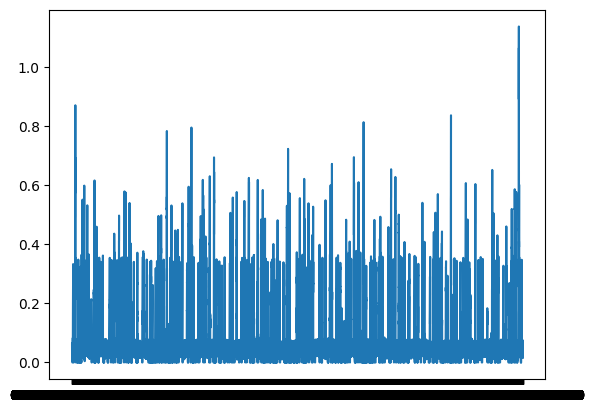

In [6]:
plt.plot(df['timestamp'], df['vibration'])

In [7]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
sensors = df.iloc[:,2:7]
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(sensors))
df1 = pd.DataFrame(df1, columns=sensors.columns)
df1['timestamp'] = df['timestamp']
df1['failure'] = df['failure']
df1['RUL'] = df['RUL']
df1['motor_id'] = df['motor_id']
df1.head()

,temp,vibration,current,line_speed,coil_thickness,timestamp,failure,RUL,motor_id
0,0.403176,0.053904,0.623217,0.691084,0.174312,01-01-2023 00:00,0,64,M01
1,0.486716,0.023133,0.356187,0.647879,0.082569,01-01-2023 00:00,0,63,M04
2,0.541782,0.040029,0.554758,0.674135,0.174312,01-01-2023 00:00,0,62,M02
3,0.438160,0.037731,0.390156,0.741320,0.082569,01-01-2023 00:00,0,61,M03
4,0.738256,0.044330,0.489449,0.682700,0.082569,01-01-2023 00:00,0,60,M05


In [8]:
#train-test split giving 65% of each motors data to train and rest to test
train_l = []
test_l = []
for id in df1['motor_id'].unique():
    df2 = df1[df1['motor_id']== id]
    train_size = int(len(df2)*0.65)
    train_l.append(df2.iloc[:train_size])
    test_l.append(df2.iloc[train_size: ])
train = pd.concat(train_l).reset_index(drop=True)
test = pd.concat(test_l).reset_index(drop=True)

In [9]:
train.sample(5)

,temp,vibration,current,line_speed,coil_thickness,timestamp,failure,RUL,motor_id
5084,0.714223,0.032679,0.517423,0.706283,0.000000,16-01-2024 20:00,0,129,M01
8294,0.706123,0.039931,0.495021,0.748112,0.000000,06-03-2023 18:00,0,135,M04
3493,0.215872,0.000000,0.252437,0.435325,0.449541,11-04-2023 13:00,0,28,M01
32347,0.580806,0.065030,0.348716,0.523158,0.266055,19-11-2023 11:00,0,36,M05
31721,0.582083,0.042814,0.480985,0.771377,0.082569,18-01-2023 09:00,0,67,M05


In [10]:
#creating time series dataset bcz LSTM need sequence as input
def create_dataset(data, time_step = 1):
    X, y_failure, y_RUL = [],[],[]
    group_data = data.groupby('motor_id')
    for motor_id, motor_data in group_data:
        X_data = data.iloc[:,0:5].values
        failure = data.iloc[:,6].values
        RUL = data.iloc[:,7].values
        for i in range(len(data)-time_step):
            a = X_data[i:i+time_step]
            X.append(a)
            y_failure.append(failure[i+time_step])
            y_RUL.append(RUL[i+time_step])
    return np.array(X), np.array(y_failure), np.array(y_RUL)

time_step = 24
X_train, y_train_failure, y_train_RUL = create_dataset(train, time_step)
X_test, y_test_failure, y_test_RUL = create_dataset(test, time_step)

In [11]:
np.shape(X_train)

(162380, 24, 5)

In [12]:
X_train.shape, X_test.shape

((162380, 24, 5), (87380, 24, 5))

In [13]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [14]:
#building the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)

failure = Dense(1, activation='sigmoid', name='failure')(x)
rul = Dense(1, activation='linear', name='rul')(x)

model = Model(inputs=input_layer, outputs=[failure, rul])

In [15]:
model.compile(
              optimizer='adam',
              loss={'failure': 'binary_crossentropy', 'rul': 'mean_squared_error'},
              loss_weights = {'failure': 10.0, 'rul': 0.1}
              )

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     17,920 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24, 64)    │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 64)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     12,416 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ failure (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rul (Dense)         │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,426 (247.76 KB)

 Trainable params: 63,426 (247.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from sklearn.preprocessing import MinMaxScaler

rul_scaler = MinMaxScaler()
y_train_RULs = rul_scaler.fit_transform(y_train_RUL.reshape(-1, 1))
y_test_RULs = rul_scaler.transform(y_test_RUL.reshape(-1, 1))
y_train_RULs = y_train_RULs.flatten()
y_test_RULs = y_test_RULs.flatten()
print("y_train_RULs shape (after flatten):", y_train_RULs.shape)

y_train_RULs shape (after flatten): (162380,)


In [18]:
history = model.fit(
    X_train,
    {'failure': y_train_failure, 'rul': y_train_RULs},
    epochs=10,
    batch_size=48,
    validation_data=(X_test, {'failure': y_test_failure, 'rul': y_test_RULs})
)

Epoch 1/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - failure_loss: 0.1091 - loss: 1.0991 - rul_loss: 0.0807 - val_failure_loss: 0.0896 - val_loss: 0.9001 - val_rul_loss: 0.0338
Epoch 2/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - failure_loss: 0.0966 - loss: 0.9681 - rul_loss: 0.0232 - val_failure_loss: 0.0859 - val_loss: 0.8622 - val_rul_loss: 0.0338
Epoch 3/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - failure_loss: 0.0902 - loss: 0.9047 - rul_loss: 0.0224 - val_failure_loss: 0.0830 - val_loss: 0.8330 - val_rul_loss: 0.0318
Epoch 4/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 77s 12ms/step - failure_loss: 0.0843 - loss: 0.8449 - rul_loss: 0.0222 - val_failure_loss: 0.0793 - val_loss: 0.7961 - val_rul_loss: 0.0316
Epoch 5/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - failure_loss: 0.0855 - loss: 0.8571 - rul_loss: 0.0220 - val_failure_loss: 0.0785 - val_loss: 0.7886 - val_rul_loss: 0.0319
Epoch 6/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - failure_loss: 0.0819 - loss: 0.8

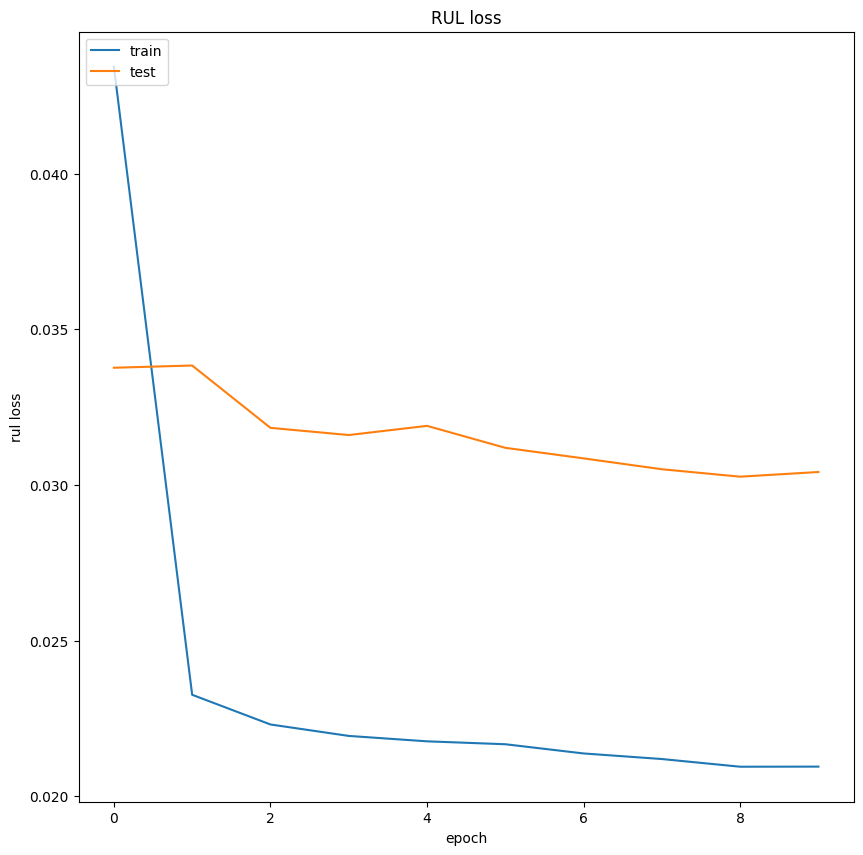

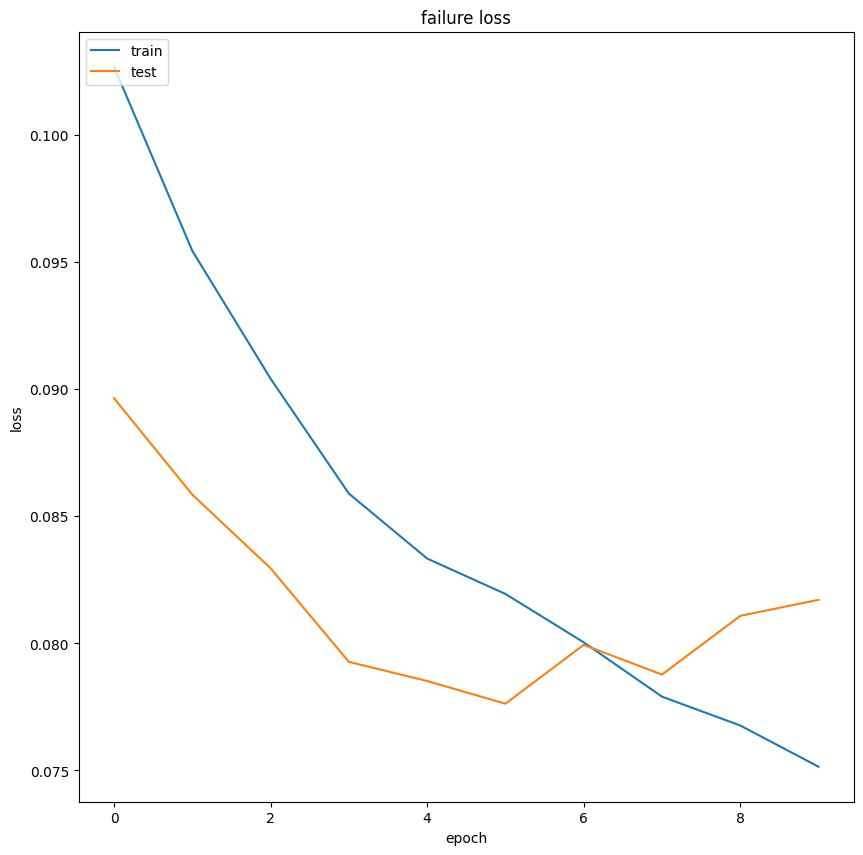

In [19]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['rul_loss'])
plt.plot(history.history['val_rul_loss'])
plt.title('RUL loss')
plt.ylabel('rul loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['failure_loss'])
plt.plot(history.history['val_failure_loss'])
plt.title('failure loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_loss.png")

In [128]:
train_p_fail, train_p_RUL = model.predict(X_train)
test_p_fail, test_p_RUL = model.predict(X_test)
test_p_fail

5075/5075 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


array([[0.01489803],
       [0.14763305],
       [0.03542129],
       ...,
       [0.01887854],
       [0.01610255],
       [0.01258012]], dtype=float32)

In [21]:
train_p_RUL = rul_scaler.inverse_transform(train_p_RUL)
test_p_RUL = rul_scaler.inverse_transform(test_p_RUL)

In [92]:
#Evaluating the model for prediction of Failure
#classification hence we use confusion metrix

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

y_pred_binary = (test_p_fail > 0.20).astype(int).flatten()
y_true = y_test_failure.flatten()

accuracy = accuracy_score(y_true, y_pred_binary)
confusion = confusion_matrix(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{confusion}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9764
Confusion Matrix:
[[85275   450]
 [ 1615    40]]
Precision: 0.0816
Recall: 0.0242
F1-Score: 0.0373


In [94]:
y_test_df = pd.DataFrame(y_test_failure, columns = ['values'])
y_test_df.describe()

,values
count,87380.000000
mean,0.018940
std,0.136315
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [95]:
(y_test_df==0).sum(),(y_test_df==1).sum()

(values    85725
 dtype: int64,
 values    1655
 dtype: int64)

In [96]:
#cheking the predictions
from math import sqrt
from sklearn.metrics import mean_absolute_error
a = sqrt(mean_absolute_error(y_train_RUL, train_p_RUL))
b = sqrt(mean_absolute_error(y_train_failure, train_p_fail))
c = sqrt(mean_absolute_error(y_test_RUL, test_p_RUL))
d = sqrt(mean_absolute_error(y_test_failure, test_p_fail))
a,b,c,d

(5.384274133411632,
 0.19334461656755117,
 5.674970302420059,
 0.19090677799296085)

In [138]:
import numpy as np

def predict_equipment_status(motor_id, full_df, model, input_scaler, rul_scaler, time_steps=24):
    samples_per_motor = 10000
    start = (motor_id - 1) * samples_per_motor
    end = motor_id * samples_per_motor

    motor_data = full_df.iloc[start:end]
    features = ['temp', 'vibration', 'current', 'line_speed', 'coil_thickness']
    sequence = motor_data[features].iloc[-time_steps:].values
    sequence_scaled = input_scaler.transform(sequence)
    sequence_scaled = sequence_scaled.reshape(1, time_step, len(features))
    print(sequence_scaled.shape)

    # Predict
    failure_prob, rul_scaled = model.predict(sequence_scaled)
    failure = failure_prob[0][0] > 0.2
    rul = rul_scaler.inverse_transform(rul_scaled)[0][0]

    print(f"Motor ID: {motor_id}")
    print(f"Failure in next 24 hours? → {'YES' if failure else 'NO'}")
    print(f"Estimated RUL: {rul:.2f} hours")
    return failure, rul


In [137]:
#takes user input as motor id
try:
    user_motor_id = int(input("Enter Motor ID (1 to 5): "))
    if user_motor_id < 1 or user_motor_id > 5:
        raise ValueError("Motor ID must be between 1 and 5.")

    predict_equipment_status(
        motor_id=user_motor_id,
        full_df=df,
        model=model,
        input_scaler=scaler,
        rul_scaler=rul_scaler
    )

except ValueError as e:
    print(f"Invalid input: {e}")

Enter Motor ID (1 to 5): 2
(1, 24, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Motor ID: 2
Failure in next 24 hours? → NO
Estimated RUL: 34.18 hours
